# Example of simulation-based model inference (SBMI)
https://arxiv.org/abs/2305.15174

In this notebook we focus on the model inference part. Therefore we only sample from a simple model prior, the graph implementation for the model prior is presented in a later notebook.

### Define model and prior

Similar to the paper we will use an "additive" model: we want to learn a one dimensional function $f(t)$ which can consist of different components, namely:
- linear component: $\theta_1^{1} t$
- quadratic component: $\theta_1^2 t^2$
- sinusoidal component: $\theta_1^3 \sin(\theta_2^3 t)$
- noise component: $n_{t_i} \sim \mathcal{N}(0, \theta_1^4)$

This results in four model components with in total five parameters, and a partition of the parameter space in $[1,1,2,1]$.

The presence/absence of the model components are indicated by a binary vector $M$. 

For simplicity we assume a flat model prior over the component one to three and we assume that the noise term is always present. 

We further assume uniform priors for all parameters $\theta_i^j$. 

In [48]:
import torch
from sbi.utils import get_parameter_mask

import matplotlib.pyplot as plt

In [80]:
n_components = 5

partition = torch.tensor([1, 1, 1, 2, 1])  # partition of the parameters

prior_bounds = torch.ones((2, partition.sum()))
prior_bounds[0] = 0.5
prior_bounds[1] = 2
# adapt priors for sine
prior_bounds[0, 2] = 3
prior_bounds[1, 3] = 10
prior_bounds[0, 3] = 1.0
prior_bounds[1, 3] = 5.0


def sample_model_components(n, n_components):
    # the last component is always 1
    m = torch.bernoulli(torch.ones((n, n_components)) * 0.5)
    m[:, -1] = 1
    return m.int()


def sample_parameters(m, prior_bounds, partition):
    n, n_components = m.shape
    thetas = torch.rand((n, prior_bounds.shape[1]))
    # scale the thetas to the prior bounds
    thetas = thetas * torch.abs(prior_bounds[1] - prior_bounds[0]) + prior_bounds[0]
    # mask the parameters that are not used
    mask = ~get_parameter_mask(m, partition)
    thetas[mask] = torch.nan
    return thetas


def run_model(m, thetas):
    n, n_components = m.shape

    thetas = thetas.clone()
    thetas[torch.isnan(thetas)] = 0

    t = torch.arange(0, 10, 0.01)

    # additive model components
    l = thetas[:, 0].unsqueeze(1) * t
    q = thetas[:, 1].unsqueeze(1) * t**2
    sin = thetas[:, 2].unsqueeze(1) * torch.sin(thetas[:, 3].unsqueeze(1) * t)

    # noise component
    noise = torch.randn(n, len(t)) * thetas[:, 4].unsqueeze(1)

    out = l + q + sin + noise

    return out


t = torch.arange(0, 10, 0.01)

n_samples = 100

m = sample_model_components(n_samples, n_components=4)
thetas = sample_parameters(m, prior_bounds, partition)
x = run_model(m, thetas)

We have created the trainingsdata $\{M, \theta, x\}$ which we will use for training. 
- $M$ has shape (n_samples, n_components)
- $\theta$ has shape (n_samples, sum(partition))
- x has shape (n, number of timepoints)

Let's have a look at the data:

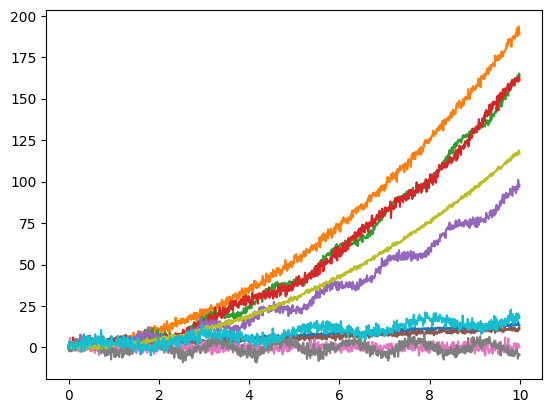

In [82]:
plt.plot(t, x[:10].T)

In [22]:
# quick check for the parameters
for i in range(partition.sum()):
    print("min,max,mean of parameter", i, ":")
    print(
        thetas[~torch.isnan(thetas[:, i]), i].min(),
        thetas[~torch.isnan(thetas[:, i]), i].max(),
        torch.nanmean(thetas[:, i]),
    )

min,max,mean of parameter 0 :
tensor(-14.8807) tensor(1.9873) tensor(-6.4300)
min,max,mean of parameter 1 :
tensor(0.5017) tensor(1.9855) tensor(1.2140)
min,max,mean of parameter 2 :
tensor(0.5637) tensor(1.9974) tensor(1.4117)
min,max,mean of parameter 3 :
tensor(0.5017) tensor(1.9931) tensor(1.2541)
min,max,mean of parameter 4 :
tensor(0.5001) tensor(1.9979) tensor(1.2629)
